In [1]:
import polars as pl
import numpy as np
import pandas as pd
import seaborn as sms
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV

from sklearn.metrics import RocCurveDisplay, confusion_matrix, classification_report, precision_score, recall_score, f1_score


import sys
import joblib
import pickle


# Predicting heart disease using ML

We will use ML(classification) to predict wether someone has heart disease or not .

Our approach:
1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modeling
6. Experimentation


## 1. Problem Definition
> Given clinical parameters about a patient, can we predict whether or not they have a heart disease?


## 2. Data
UCI heart disease dataset (from Kaggle).
* Url: 
https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset


## 3. Evaluation
> If we can reach 95% accuracy with our prediction during the proof of concept, we'll pursue the project.

## 4. Features

* age (years)
* sex (1 = male, 0 = female)
* cp = chest pain type (4 values)
* trestbps = resting blood pressure
* chol = serum cholesterol in mg/dl
* fbs = fasting blood sugar > 120 mg/dl
* restecg = resting electrocardiographic results (values 0,1,2)
* thalach = maximum heart rate achieved
* exang = exercise induced angina
* oldpeak = ST depression induced by exercise relative to rest
* slope =the slope of the peak exercise ST segment
* ca = number of major vessels (0-3) colored by fluoroscopy
* thal: 0 = normal; 1 = fixed defect; 2 = reversible defect
* target : 0 or 1 (have disease or not)


## Load data

In [2]:
df = pd.read_csv('./data/heart-disease.csv')
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


## Data Exploration (exploratory data analysis EDA)


In [3]:
# checking the balance of the data (target)
df.target.value_counts()

1    165
0    138
Name: target, dtype: int64

<Axes: >

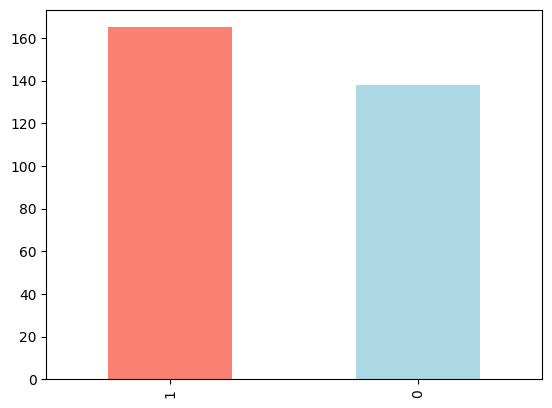

In [4]:
df.target.value_counts().plot(kind='bar', color=['salmon', 'lightblue'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [6]:
# checking if there is missing data
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [7]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


### Heart disease frequency according to `Sex`

In [8]:
df.sex.value_counts()

1    207
0     96
Name: sex, dtype: int64

In [9]:
# Compare `target` column to `sex` column
pd.crosstab(df.target, df.sex)

sex,0,1
target,,
0,24,114
1,72,93


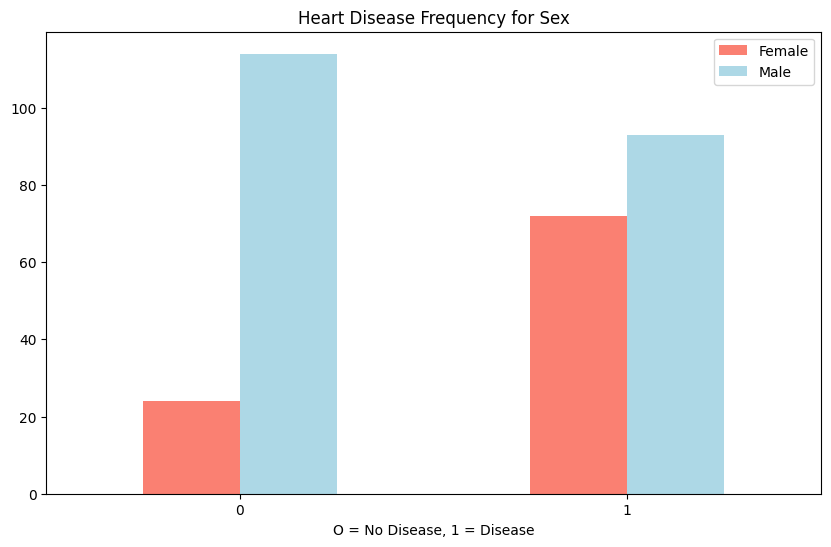

In [10]:
pd.crosstab(df.target, df.sex).plot(kind='bar',
                                    figsize=(10,6),
                                    color=['salmon', 'lightblue']);
plt.title('Heart Disease Frequency for Sex')
plt.xlabel('O = No Disease, 1 = Disease')
plt.legend(['Female', 'Male'])
plt.xticks(rotation=0);

### `age` vs `thalach` for Heart disease 

In [11]:
df.thalach.value_counts()

162    11
160     9
163     9
152     8
173     8
       ..
202     1
184     1
121     1
192     1
90      1
Name: thalach, Length: 91, dtype: int64

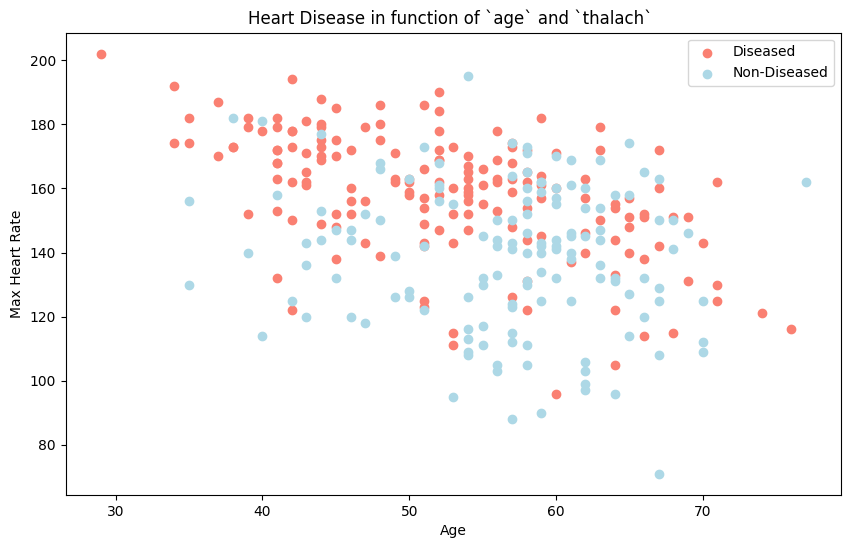

In [18]:
plt.figure(figsize=(10,6))

# positive examples
plt.scatter(df.age[df.target==1],
            df.thalach[df.target==1],
            c='salmon')

# negative example
plt.scatter(df.age[df.target==0],
            df.thalach[df.target==0],
            c='lightblue')

# Info
plt.title('Heart Disease in function of `age` and `thalach` ')
plt.xlabel('Age')
plt.ylabel('Max Heart Rate')
plt.legend(['Diseased', 'Non-Diseased']);

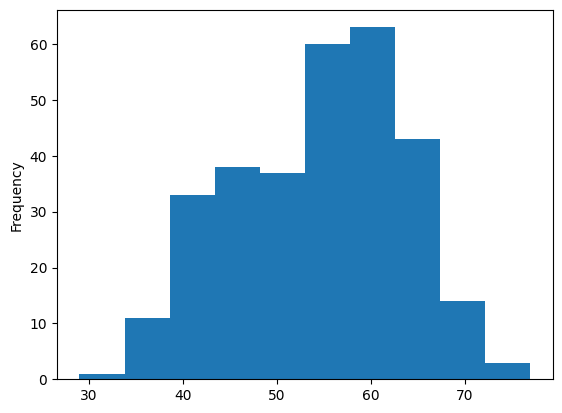

In [21]:
# Distribution of age 
df.age.plot.hist();